# Salary Predictions Based on Job Descriptions

## Table of contents

### 1. Data quality check
* Libraries import and default configuration.
* Classes definition.
* Data load, merge, inspection and cleaning.

### 2. Descriptive statistics
* General overview.
* Features distribution.
* Correlation matrix.

### 3. Exporatory data analysis
* Features statistics analysis.

### 4. Data pre-processing
* Data split and features engineering.

### 5. Model development
* Baseline.
* Model development and validation.
* Best model selection and feature importance.
* Save model and predictions to disk.

In [1]:
__author__ = "Juan Vicente Peluso"
__email__ = "vpeluso@gmail.com"

## 1. Data quality check

* **Libraries import and default configuration.**

First, we import the requested libraries and set the default configurations for the notebook.

In [2]:
# Ignore deprecation warnings in sklearn
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import os
import re
import math
import json
import config
import timeit
import pickle
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import seaborn as sns
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

# Default global configurations
rndSt = config.RANDOM_SEED
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
tab10C = plt.get_cmap('tab10', 10)
pieColors = tab10C(np.linspace(0, 1, 10))

print('Libraries imported and default configuration set!')

Libraries imported and default configuration set!


* **Classes definition**

Here the classes are defined in a format that in the future help to create the file to put the model in production.

In [3]:
class dataHandler():
    
    ''' ### Class that loads, process and transform the data ### '''
    
    def __init__(self):
        
        # Files location
        self.file_trainF = config.TRAIN_FEATURES
        self.file_trainT = config.TRAIN_TARGET
        self.file_testF = config.TEST_FEATURES
        
        # Features and target names
        self.featuresN = config.FEATURES
        self.targetN = config.TARGET
        self.targetNP = config.TARGET_PRETTY
        self.numFeaturesN = config.NUM_FEATURES
        self.numFeaturesNP = config.NUM_FEATURES_PRETTY
        self.numFeaturesTarg = config.NUM_FEATURES_TARGET
        self.numFeaturesTargP = config.NUM_FEATURES_TARGET_PRETTY
        self.catFeaturesN = config.CAT_FEATURES
        self.catFeaturesNP = config.CAT_FEATURES_PRETTY
        self.mergeCol = config.MERGE_COL
        self.logFeatures = config.LOG_FEATURES
        self.trainValPerc = config.TRAIN_VAL_PERC
        self.finalFeatures = config.FINAL_FEATURES
        self.dropFeatures = config.DROP_FEATURES
        
        # Default configurations
        self.printInfo = config.PRINT_INFO
        self.checkZerosTr = config.CHECK_ZEROS_TRAIN
        self.delDuplTr = config.DEL_DUPL_TRAIN
        self.delNANTr = config.DEL_NAN_TRAIN
        self.checkZerosTs = config.CHECK_ZEROS_TEST
        self.delDuplTs = config.DEL_DUPL_TEST
        self.delNANTs = config.DEL_NAN_TEST
        self.delDuplCols = config.DEL_DUPL_COLS
        
        # Model development configurations
        self.bslFeatures = config.BASELINE_FEATURES
        
    def loadMergeCheck(self):

        ''' Load the data, merge dataframes and runs data integrity processes '''

        self.trainF = self.loadCsv(self.file_trainF)
        self.trainT = self.loadCsv(self.file_trainT)
        self.testF = self.loadCsv(self.file_testF)
        print('Files loaded in dataframes')
        self.trainAll = self.mergeDF(self.trainF, self.trainT, self.mergeCol)
        print('Train datasets merged\n\n### Checking Train dataframe ###\n')
        self.checkAll(self.trainAll, delNAN = self.delNANTr, checkZeros = self.checkZerosTr, 
                      zeroCol = self.targetN, delDupl = self.delDuplTr, delDuplCols = self.delDuplCols, 
                      printInfo = self.printInfo)
        print('\n### Checking Test dataframe ###\n')
        self.checkAll(self.testF, delNAN = self.delNANTs, checkZeros = self.checkZerosTs, 
                      zeroCol = self.targetN, delDupl = self.delDuplTs, delDuplCols = self.delDuplCols, 
                      printInfo = self.printInfo)

    def loadCsv(self, fileName):
        
        ''' Load a CSV file into a Pandas Dataframe
        
        Arguments
        ---------
        df1:         Pandas dataframe. '''
        
        df = pd.read_csv(fileName)
        return df
    
    def mergeDF(self, df1, df2, onCol):
        
        ''' Merges 2 Pandas Dataframe
        
        Arguments
        ---------
        df1:         Pandas dataframe 1.
        df2:         Pandas dataframe 2.
        onCol:       Columns on which do the merge. '''
        
        df = df1.merge(df2, on = onCol)
        return df
    
    def checkAll(self, df, delNAN = False, checkZeros = False, zeroCol = '', delDupl = False, delDuplCols = '',
                 printInfo = False):
        
        ''' Function that call the processes that check data integrity on a given dataframe.

        Arguments
        ---------
        df:          Pandas dataframe.
        delNAN:      Boolean value to delete or not NAN values, by default False.
        checkZeros:  Boolean value to check or not zero value on a given column, by default False.
        zeroCol:     Column to check the zero values, by default empty.
        delDupl:     Boolean value to delete duplicates values during the check, by default False.
        delDuplCols: Column subset to check the duplicates in a dataframe, by default is empty.  
        printI:      Boolean value to print or not dataframe info, by default False. '''
        
        try:
            if isinstance(df, pd.DataFrame) : DF = df
        except:
            print('The file recieved isn\'t a Pandas Dataframe')

        if printInfo : self.print_Info(DF)
        self.printShape(DF)
        self.checkNaN(DF, delNAN)
        self.checkDup(DF, delDupl, delDuplCols)
        if checkZeros : 
            zeroReg = self.zeroCol(DF, zeroCol)
            if zeroReg[0] > 0 :
                self.dropRows(self.trainAll, zeroReg[1])
                self.dropRows(self.trainT, zeroReg[1])
                print('@@@ {} = 0 rows successfully deleted @@@'.format(zeroCol))
    
    def print_Info(self, df):
        
        ''' Function that prints the info of a given dataframe.

        Arguments
        ---------
        df:          Pandas dataframe. '''
        
        print('Dataframe information\n---------------------')
        print('{}\n'.format(df.info()))
    
    def printShape(self, df):
        
        ''' Function that prints the shape of a given dataframe.

        Arguments
        ---------
        df:          Pandas dataframe. '''
            
        print('Dataframe shape\n---------------')
        print('{}\n'.format(df.shape))

    def checkNaN(self, df, Del = False):
        
        ''' Function that looks for Nan values of a given dataframe, and deleted if requested.

        Arguments
        ---------
        df:          Pandas dataframe.
        Del:         Boolean value to delete or not Nan rows, by default False. '''
            
        nan = np.sum(df.isna().sum())
        print('NaN values\n----------')
        if nan > 0:
            if Del:
                df.dropna()
                print('{} rows with NaN values\nNaN rows successfully deleted\n'.format(nan))
            else : print('{} rows with NaN values\n'.format(nan))
        else : print('{} rows with NaN values\n'.format(nan))

    def checkDup(self, df, Del = False, dupC = ''):
        
        ''' Function that looks for duplicated rows of a given dataframe, and deleted if requested.

        Arguments
        ---------
        df:          Pandas dataframe.
        Del:         Boolean value to delete or not Nan rows, by default False.
        dupC:        Column subset to check the duplicates in a dataframe, by default is empty. '''
        
        if not isinstance(dupC, list):
            self.variables = [dupC]
        else:
            self.variables = dupC
            
        dup = df.duplicated(subset = dupC).sum()
        print('Duplicated rows\n---------------')
        if dup > 0:
            if Del:
                df.drop_duplicates(subset = dupC)
                print('{} duplicated rows\nDuplicated rows successfully deleted\n'.format(dup))
            else : print('{} duplicated rows\n'.format(dup))
        else : print('{} duplicated rows\n'.format(dup))

    def zeroCol(self, df, col):
        
        ''' Function that looks for zero values on a given column, return the count and the its indexes.

        Arguments
        ---------
        df:          Pandas dataframe.
        col:         Column to check zero values. '''
        
        zeros = df[df[col] <= 0].count()[0]
        print('{} == 0 (zero) validation'.format(col))
        print('{}-----------------------'.format('-'*int(len(col))))
        print('{} rows with value = 0'.format(zeros))
        if zeros > 0:
            return [zeros, list(df[df[col] <= 0].index)]
        else: return [0,[]]

    def dropRows(self, df, indexList):
        
        ''' Function that drop rows of a given dataframe, then reset the index.

        Arguments
        ---------
        df:          Pandas dataframe.
        indexes:     Rows indexes to delete. '''
        
        df.drop(indexList, inplace = True)
        df.reset_index(inplace = True, drop = True)
        
    def dropCols(self, df):
        
        ''' Function that drop columns of a given dataframe.

        Arguments
        ---------
        df:          Pandas dataframe. '''
        
        X = df.copy()
        if not isinstance(self.dropFeatures, list):
            dropF = [self.dropFeatures]
        else:
            dropF = self.dropFeatures
        X.drop(dropF, axis=1, inplace = True)
        return X
        
    def splitTrainVal(self, df, X , y):
        
        ''' Split data into train and validation datasets
        
        Arguments
        ---------
        df:          Pandas dataframe (Full data). 
        X:           Features dataframe.
        y:           Target feature dataframe. '''
        
        X = self.dropCols(X)
        self.trainX,self.valX,self.trainY,self.valY = train_test_split(X, y, test_size = self.trainValPerc, 
                                                                       random_state = rndSt)
        print('Data splitted in train and test datasets\n')
        
        print('=====================================')
        print('Full dataset shape   --> ', df.shape)
        print('Train features shape --> ', self.trainX.shape)
        print('Test features shape  --> ', self.valX.shape)
        print('Train target shape   --> ', self.trainY.shape)
        print('Test target shape    --> ', self.valY.shape,)
        print('=====================================\n')
        

In [4]:
class dataAnalysis():
    
    ''' ### Class that performs operations to analyze the data ### '''
    
    def objectCheck(self, df, limitV, dType, dropC = ''):
        
        ''' Function that returns statistics of a given dtype features of a given dataframe.

        Arguments
        ---------
        df:          Pandas dataframe.
        limitV:      Limit of unique values to print them or not.
        dType:       Data type to evaluate.
        dropC:       Columns to drop from the statistics .'''
        
        if not isinstance(dropC, list):
            self.dropC = [dropC]
        else:
            self.dropC = dropC
            
        self.uniqCat(df, limitV)
        print('\n')
        return df[dataH.catFeaturesN].astype(dType).describe().transpose().drop(self.dropC)
    
    def uniqCat(self, df, limitV):
        
        ''' Function that prints the unique values of a given columns.

        Arguments
        ---------
        df:          Dataframe.
        limitV:      Limit of unique values to print them or not. '''
        
        for item in dataH.catFeaturesN:
            if len(df[item].unique()) < limitV :
                print('{} --> {}'.format(item, list(df[item].unique())))
                
    def aggData(self, df, group, agg, aggM, sort = '', asc = True):
        
        ''' Function groups and aggregates data of a given dataframe, and returns it.

        Arguments
        ---------
        df:          Pandas dataframe.
        group:       Group column
        agg:         Aggregate column
        aggM:        Aggregate method
        sort:        Column to sort by, by default empty.
        asc:         Sort in ascending manner, by default True. '''
        
        if not isinstance(sort, list):
            self.sort = [sort]
        else:
            self.sort = sort
            
        DF = df.groupby(group).agg({agg : aggM}).reset_index()
        if len(sort)>0 :
            DF.sort_values(by=sort, ascending=asc, inplace=True)
        return DF
    
    def pivotData(self, df, index, col, val):
        
        ''' Function pivots a given dataframe, and returns it.

        Arguments
        ---------
        df:          Pandas dataframe.
        index:       Pivot index.
        col:         Pivot column.
        val:         Pivot values. '''
        
        return df.pivot(index=index, columns=col, values=val)
    
    def rangeAnalysis(self, df1, df1Col, df2):
        
        ''' Function that makes a value range analysis on dataframes and return a new dataframe.

        Arguments
        ---------
        df1:       Pandas dataframe 1.
        df1Col:    df1 column to analyze.
        df2:       Pandas dataframe 2. '''
        
        txt = 'mean salary per company --> '
        diff = df1[df1Col].max()-df1[df1Col].min()
        print('Min {}{:.2f}'.format(txt, df1[df1Col].min()))
        print('Max {}{:.2f}'.format(txt, df1[df1Col].max()))
        print('Range between --> {:.2f}'.format(diff))
        df2['Min'] = df2.min(axis=1)
        df2['Max'] = df2.max(axis=1)
        df2['Range'] = df2['Max'] - df2['Min']
        df2.sort_values(by='Range', ascending = False)
        txt = 'Salary range mean per company and jobType -->'
        print('{} {:.2f}\n'.format(txt, df2['Range'].mean()))
        df3 = df2[['Min', 'Max', 'Range']].reset_index()
        df3.set_index('jobType', inplace=True)
        return df3
    
    def createBaseline(self, X, y, BSFeatures):
        
        ''' Function that calculate the mean target value of a group, map it, and return the 
            mean, which will be considered as the baseline to compare with future models.

        Arguments
        ---------
        X:           Features dataframe.
        y:           Target feature dataframe.
        BSFeatures:  Features to group target feature and calculate the mean (baseline)'''

        if not isinstance(BSFeatures, list):
            bslFeatures = [BSFeatures]
        else:
            bslFeatures = BSFeatures
            
        # persist transforming dictionary
        self.dctBaseline_ = {}
        X = X.copy()
        tmpDF = pd.concat([X[bslFeatures], y], axis=1)
        tmpDF = dataA.aggData(tmpDF, bslFeatures, dataH.targetN, np.mean)
        
        for k in range(len(bslFeatures)):
            if k == 0 :
                tmpDF['key'] = tmpDF[bslFeatures[k]]
                X['key'] = X[bslFeatures[k]]
            else:
                tmpDF['key'] = tmpDF['key'] + tmpDF[bslFeatures[k]]
                X['key'] = X['key'] + X[bslFeatures[k]]
                
        tmpDF.set_index('key', inplace = True)
        tmpDF.drop(bslFeatures, axis=1, inplace = True)
        DC = tmpDF.to_dict()
        self.dctBaseline_ = DC['salary'] 
        X['Prediction'] = X['key'].map(self.dctBaseline_)
        
        mse = mean_squared_error(X['Prediction'], y)
        rmse = math.sqrt(mse)
        print('Baseline RMSE --> {:.4f}'.format(rmse))
        
    def CVS(self, pipe, name, X, y, cv = 4, n_jobs = 3, scoring = 'neg_mean_squared_error', verbose = 0):
        
        ''' Function that apply cross_val_score function and returns scores and execution time.

        Arguments
        ---------
        pipe:        Pipeline to evaluate.
        name:        Pipeline model name.
        X:           Features dataframe.
        y:           Target value dataframe. 
        cv:          Number of folders to evaluate, by default 4.
        n_jobs:      Number of parallel jobs, by default 3.
        scoring:     Score to evaluate, neg_mean_squared_error by default.
        verbose:     Verbose level, by default 0.'''
        
        Start = timeit.default_timer()
        CVScores = cross_val_score(pipe, X, y,  cv = cv, n_jobs = n_jobs, 
                                   scoring = scoring, verbose = verbose)
        CVScores = [np.sqrt(-1*x) for x in CVScores]
        End = timeit.default_timer()
        Time = End - Start
        return [name, Time, CVScores, np.mean(CVScores)]
    
    def getTime(self, sec):
        
        ''' Function that returns the time formatted.

        Arguments
        ---------
        sec:         Seconds. '''
        
        if sec <=0 :
            return '0 seconds'

        if math.ceil(sec) < 60 :
            return '{:d} second(s)'.format(math.ceil(sec))
        elif math.ceil(sec) < 3600 :
            Min, Sec = divmod(math.ceil(sec), 60)
            return '{:d} minute(s) {:d} second(s)'.format(int(Min), int(math.ceil(Sec)))
        else:
            Min, Sec = divmod(math.ceil(sec), 60)
            Hour, Min = divmod(Min, 60)
            return '{:d} hour(s) {:d} minute(s) {:d} second(s)'.format(int(Hour), int(Min), int(Sec))
    
    def showCVResults(self, lstResults, lstFig, lstTitles, width = 0.85, factor = 1, nType = '',
                      plotC = 'b', sep = [1,2,3], div = 2.5):
        
        ''' Function draw plots of the results of the cross validation process.

        Arguments
        ---------
        lstResults:  Results list.
        lstFig:      Figures object to plot in.
        lstTitles:   Plot title list.
        width:       Bar width. 
        factor:      Factor to adjust text above the bars.
        nType:       Numeric type of the values above the bars, by default empty.
        plotC:       Plot color, by default blue.
        sep:         Separator list, in function of the value of the bar, by default [1,2,3].
        div:         Factor to adjust the text next to the horizontal bars. '''
        
        names = [X[0] for X in modelS]
        times = [X[1] for X in modelS]
        scores = [X[2] for X in modelS]
        
        pg.plotLine(scores, names, lstFig[0], lstTitles[0], lstTitles[1], lstTitles[2])
        pg.plotBarH(names, np.array(times), lstFig[1], lstTitles[3], width, factor, nType = nType, plotC = plotC, 
                    sep = sep, div = div)

In [5]:
class plotGraph:
    
    ''' ### Class that draw plots ### '''
    
    def __init__(self):
        self.colors = config.PLOT_COLORS
        self.cmap = self.colorMap()
        self.setStyle()

    def setStyle(self, style = 'darkgrid'):
        
        ''' Function sets the seaborn color style.

        Arguments
        ---------
        style:       Style name, by default darkgrid. '''
        
        sns.set(style = style)
    
    def colorMap(self):
        
        ''' Create a custom colormap '''
        dctColors = {}
        for ind, color in zip(range(len(self.colors)), self.colors) :
            dctColors.update({ind : color})

        cm = clr.ListedColormap([dctColors[x] for x in dctColors.keys()])
        return cm
        
    def plotDist(self, arr, fig, title, bins = 0, lblFS = 11, plotC = 'skyblue', yLbl = ''):
        
        ''' Function that draws a distribution plot.

        Arguments
        ---------
        arr:         Array of data to plot.
        fig:         Figure.
        title:       Plot title.
        bins:        Number of bins, by default 0.
        lblFS:       Labels font size, by default 11.
        plotC:       Plot color, by default skyblue.
        yLabel:      Label for the Y axis, by default empty. '''
        
        if bins == 0 :
            ds = sns.distplot(arr, kde=False, color = plotC)
        else :
            ds = sns.distplot(arr, kde=False, color = plotC, bins = bins)
            
        plt.title(title, fontsize = 13)   
        plt.xlabel('')
        plt.ylabel(yLbl)
        plt.tick_params(top=False, bottom=True, left=True, right=False)
        plt.tick_params(axis='both', which='major', labelsize=lblFS)

    def plotPie(self, arr, fig, colors, title, titleFS = 12, pieFS = 10, 
                startA = 90, pct = False, pctD = 0.7, legLoc = 0):
        
        ''' Function that draws a pie plot.

        Arguments
        ---------
        arr:         Array of data to plot.
        fig:         Figure.
        colors:      Colors array for the pie sections.
        title:       Plot title.
        titleFS:     Title font size, by default 12.
        pieFS:       Pie labels font size, by default 10.
        startA:      Start angle of the pie, by default 90.
        pct:         Boolean value to print percetages instead of values, by default False.
        pctD:        Distance of the percentages labels from the pie center, by default 0.7.
        legLoc:      Location of the legend, by default 0. '''
        
        self.setStyle('white')
        if pct : 
            _ = plt.pie(arr, autopct='%1.1f%%', startangle=startA, colors = colors, pctdistance=pctD, 
                        textprops={'size': pieFS, 'weight' : 'semibold'}, wedgeprops={'alpha' : 0.65})
        else :
             _ = plt.pie(arr, startangle=startA, colors = colors,
                        textprops={'size': pieFS, 'weight' : 'semibold'}, wedgeprops={'alpha' : 0.65})
                
        plt.axis('off')
        fig.axis('equal') 
        plt.title(title, fontsize=titleFS)
        
        if legLoc == 0 :
            plt.legend(arr.index,frameon=False, loc = legLoc, fontsize = 10)
        else :    
            plt.legend(arr.index,frameon=False, bbox_to_anchor=(legLoc), fontsize = 10)

    def plotMean(self, mean, std, fig, xLbl, yLbl, title, lblFS = 10, 
                 titleFS = 15, plotC = 'b'):
        
        ''' Function that draws a line plot of the mean and STD given.

        Arguments
        ---------
        mean:        Mean array.
        std:         STD array.
        fig:         Figure.
        xLbl:        Label for the X axis.
        yLbl:        Label for the Y axis.
        lblFS:       Labels font size, by default 10.
        titleFS:     Title font size, by default 12.
        plotC:       Plot color, by default blue. '''
        
        self.setStyle()
        plt.plot(mean, color = plotC)
        plt.fill_between(range(len(mean.index)), mean.values-std.values, mean.values+std.values, \
                         alpha = 0.15)
        plt.title(title, fontsize = titleFS, y = 1.05)
        plt.tick_params(top=False, bottom=True, left=True, right=False,
                        labelleft=True, labelbottom=True)
        plt.xlabel(xLbl, fontsize = lblFS)
        plt.ylabel(yLbl, fontsize = lblFS)

    def plotBarH(self, X, y, fig, title, width, factor, nType = '', symbol = '', 
                 fontS = 10, plotC = 'b', sep = [1,2,3], div = 3.25):
        
        ''' Function that draws an horizontal tuned bar plot.

        Arguments
        ---------
        X:           X axis values.
        y:           y axis values.
        fig:         Figure.
        title:       Plot title.
        width:       Width of the bars.
        factor:      Factor to adjust text above the bars.
        nType:       Numeric type of the values above the bars, by default empty.
        symbol:      Symbol to join the values above the bars, by default empty.
        fontS:       Font size of the values above the bars, by default 10.
        plotC:       Plot color, by default blue.
        sep:         Separator list, in function of the value of the bar, by default [1,2,3].
        div:         Factor to adjust the text next to the horizontal bars. '''
        
        self.setStyle('white')
        br = plt.barh(X, y, color = plotC, alpha = 0.7)
        plt.title(title, fontsize = 13, y = 1.05)
        plt.yticks(fontsize = 11)
        plt.xticks(fontsize = 0)
        plt.rcParams['axes.facecolor'] = 'white'
        l, r = plt.xlim()
        plt.xlim(left=(y.min()*0.6))
        plt.tick_params(top=False, bottom=False, left=False, right=False,
                        labelleft=True, labelbottom=False)
        
        for spine in plt.gca().spines.values():
            spine.set_visible(False)

        for bar in br:
            width = bar.get_width()
            if nType == 'double':
                sepV = sep[0] if width < 100 else sep[1]
                width  = str('{0:.2f}'.format(width)) + symbol
                plt.gca().text((bar.get_width()-sepV), bar.get_y() + bar.get_height()/div, str(width),
                               ha='center', color='black', fontsize=fontS)
            else:
                if width < 50 : 
                    sepV = sep[0]
                elif width < 500 : 
                    sepV = sep[1] 
                else: 
                    sepV = sep[2]
                plt.gca().text((bar.get_width()+sepV), bar.get_y() + bar.get_height()/div, 
                                dataA.getTime(math.ceil(width)), ha='center', color='black', fontsize=fontS)

    def plotMultBar(self, df, figSize, title, yLim, yTicksFS = 10, bLeg = True, legLoc = 0):
        
        ''' Function that draws a bar plot.

        Arguments
        ---------
        df:          Pandas dataframe.
        figSize:     Figure size.
        title:       Plot title.
        yLim:        Limits of the Y axis.
        yTicksFS:    Y tick labels font size, by default 10.
        legLoc:      Location of the legend, by default 0. '''
        
        self.setStyle()
        df.plot.bar(figsize = (figSize), width = 0.85, colormap = self.cmap, linewidth = 0.35, 
                    ylim = yLim, rot = 0, alpha = 0.8)
        plt.title(strTitle, fontsize = 13, y = 1.05)
        plt.yticks(np.arange(np.min(plt.yticks()[0]),np.max(plt.yticks()[0]),10),fontsize = yTicksFS)
        plt.tick_params(top=False, bottom=False, left=True, right=False)
        plt.xlabel('')
        
        if bLeg == True :
            if legLoc == 0 :
                plt.legend(loc = legLoc, frameon = False)
            else : plt.legend(bbox_to_anchor=(legLoc), frameon = False)
        else : plt.legend('', frameon = False)

    def plotCorr(self, corr, fig, title, titleFS = 15, cmap = 'blues', annot = True, 
                 square = True, fmt = '.2f', vMM = [-1,1], lineW = 0.25, cbarD = {}, 
                 annD = {}, ticksFS = 10, rot = 0, yLim = [0.0,0.0]):
        
        ''' Function that draws a correlation matrix (Heatmap).

        Arguments
        ---------
        corr:        Correlation dataframe.
        fig:         Figure.
        title:       Plot title.
        titleFS:     Title font size, by default 15.
        cmap:        Color map for the heatmap, by default blues.
        annot:       Boolean value to print the correlation scores, by default True.
        square:      Boolean value to force square shape of the heatmap, by default True.
        fmt:         Format of the annotations, by default 2 decimals.
        vMM:         Min and Max values for the color bar of the heatmap, by default [-1,1].
        lineW:       Border line width of the heatmap, by default 0.25.
        cBarD:       Color bar dictionary of properties, by default {}.
        annD:        Annotations dictionary of properties, by default {}.
        ticksFS:     Tick labels font size, by default 10.
        rot:         Rotation angle of X axis labels, by default 0.
        yLim:        Y axis plot limits, by default [0.0,0.0] '''
        
        sns.heatmap(corr, cmap=cmap, annot=annot, square=square, fmt=fmt, vmin=vMM[0], 
                    vmax=vMM[1], linewidths=lineW, cbar_kws=cbarD, annot_kws=annD)

        plt.xticks(fontsize = ticksFS, rotation = rot, ha = 'right')
        plt.yticks(fontsize = ticksFS)
        plt.title(title, fontsize = titleFS)
        b,t = plt.ylim()
        plt.ylim(bottom=(b*yLim[0]), top = (t*yLim[1]))
            
    def plotBox(self, col, fig, title, whis = 1.5, ticksFS = 11, plotC = 'g'):
        
        ''' Function that draws a box plot.

        Arguments
        ---------
        col:         Array of values.
        fig:         Figure.
        title:       Plot title.
        whis:        Whisker value of the plot.
        ticksFS:     Tick labels font size, by default 11.
        plotC:       Plot color, by default green. '''

        boxP = sns.boxplot(x = col, color = plotC, whis = whis)
        plt.title(title, fontsize = 13, y = 1.05)
        plt.xlabel('')
        plt.tick_params(top=False, bottom=True, left=False, right=False)
    
    def plotBarText(self, X, y, fig, title, xLabel, xLabelFS = 10, rot = 45,
                    xTicksFS = 11, plotC = 'b', barW = 0.9, barTxtFS = 11):
        
        ''' Function that draws a tuned bar plot.

        Arguments
        ---------
        X:           X axis values.
        y:           y axis values.
        fig:         Figure.
        title:       Plot title.
        xLabel:      Label for the X axis.
        xLabelFS:    X axis label font size, by default 10.
        rot:         Rotation angle of X axis labels, by default 45.
        xTicksFS:    X axis tick labels font size, by default 11.
        plotC:       Plot color, by default blue.
        barW:        Width of the bars, by default 0.9.
        barTxtFS:    Font size of the values above the bars, by default 11. '''
                
        _ = plt.bar(X, y, width = barW, color = plotC, alpha = 0.75)
        plt.title(title, fontsize = 15, fontweight = 450)
        plt.xlabel(xLabel, fontsize = xLabelFS)
        plt.tick_params(top=False,bottom=False,left=False,right=False,labelleft=False,labelbottom=True)
        plt.xticks(fontsize = xTicksFS, rotation = rot, ha = 'right')
        plt.grid(b=False)
        b,t = plt.ylim()
        plt.ylim(top=(t*1.075))
        for spine in plt.gca().spines.values():
            spine.set_visible(False) if spine.spine_type !='bottom' else spine.set_visible(True)
        for bar in _:
            height = bar.get_height()
            txtHeight = str(np.around(height,decimals=2))+'%'
            plt.gca().text(bar.get_x() + bar.get_width()/1.85, (bar.get_height()+0.85), txtHeight,
                           ha='center', color='black', fontsize=barTxtFS)
            
    def plotLine(self, X, lstLbls, fig, xLbl, yLbl, title, titleFS= 14, lblFS = 12, ticksFS = 10, 
                 lineW = 1.5):

        ''' Function that draws a line plot.

        Arguments
        ---------
        X:           Values to plot.
        lstLbls:     List of labels.
        fig:         Figure.
        xLabel:      Label for the X axis.
        yLabel:      Label for the y axis.
        title:       Plot title.
        titleFS:     Title font size, by default 14.
        lblFS:       Labels font size, by default 12.
        ticksFS:     Ticks font size, by default 12.
        lineW:       Width of the lines, by default 1.5. '''
        
        lowerR = math.floor(min(min(X)))
        upperR = math.ceil(max(max(X)))+0.5
        xTicks = [X+1 for X in range(len(X)+1)]
        yTicks = np.arange(lowerR, upperR,0.2)
        for scores, lbl in zip(X, lstLbls):
            mean = np.mean(scores)
            lbl = lbl + ' ({:.4f})'.format(mean)
            plt.plot(xTicks, scores, linewidth = lineW, label = lbl) 
        plt.xlabel(xLbl, fontsize = lblFS)
        plt.ylabel(yLbl, fontsize = lblFS)
        plt.title(title, fontsize = titleFS)
        plt.xticks(xTicks, fontsize = ticksFS)
        plt.yticks(yTicks, fontsize = ticksFS)
        plt.tick_params(top=False, bottom=True, left=True, right=False,
                        labelleft=True, labelbottom=True)
        plt.legend(bbox_to_anchor=([1.35,1]), frameon = False)
        plt.show()

In [6]:
class featuresTransform():
    
    ''' ### Class that formats and transforms the data to feed the models ### '''
    
    def __init__(self):
        
        # Data processing configurations
        self.compFeature = config.COMP_FEATURE
        self.dummyFeat = config.DUMMY_FEAT
        self.dummyFeatNew = config.NEW_DUMMY_FEAT
        self.dummyLambda = config.DUMMY_LAMBDA
        self.groupFeatures = config.NEW_FEATURES_GROUP
        self.newFeatures = config.NEW_FEATURES
        self.groupMethod = config.NEW_FEATURES_METHOD
        self.dctNewPath = config.DCT_NEW_PATH
        self.encFeatures = config.CAT_FEATURES_ENCODE
        self.dctEncPath = config.DCT_ENC_PATH

    def getComp(self, comp):
        
        ''' Function that gets the numeric company ID.

        Arguments
        ---------
        comp:          Company ID (string). '''
        
        x = re.findall('\d+', comp)
        return int((x[0]))
    
    def createCompany(self, X):
        
        ''' Function that change the company ID from string to numeric.

        Arguments
        ---------
        X:             Pandas dataframe. '''
            
        X = X.copy()
        X[self.compFeature] = X[self.compFeature].apply(self.getComp)
        print('{} feature updated.'.format(self.compFeature))
        return X
        
    def createDummy(self, X):
        
        ''' Function that creates dummy variable on selected features.

        Arguments
        ---------
        X:             Pandas dataframe. '''
            
        if not isinstance(self.dummyFeat, list):
            features = [self.dummyFeat]
        else:
            features = self.dummyFeat
        
        if not isinstance(self.dummyFeatNew, list):
            newFeatureN = [self.dummyFeatNew]
        else:
            newFeatureN = self.dummyFeatNew
        
        if not isinstance(self.dummyLambda, list):
            lstLmb = [0, 0, 1]
        else:
            lstLmb = self.dummyLambda
        
        X = X.copy()
        for feat, featNew in zip(features, newFeatureN):
            X[featNew] = X[feat].map(lambda x : lstLmb[1] if x == lstLmb[0] else lstLmb[2])
            print('{} feature created.'.format(featNew))
        return X
    
    def createGroupFeature(self, X, y, featName, groupMethod, dctPath, fit = False, transform = False, 
                           fit_transform = False):
        
        ''' Function that creates aggregated features based on features group. If fit == True takes the 
            values of the target value features, calculate the values, creates a dictionary with the
            equivalences and save it to disk for further use. If transform == True reads the file and
            maps the value to avoid data leakage.

        Arguments
        ---------
        X:             Features dataset.
        y:             Target feature dataset.
        featName:      Name of the new feature.
        groupMethod:   Aggregation method.
        dctPath:       Path to dump the dictionary with the equivalences.
        fit:           Boolean value to do the aggregation, create the dictionary and dump it, by default False.
        transform:     Boolean value to read the dictionary and map the values, by default False.
        fit_transform: Boolean value to do both, fit and transform, by default False. '''
        
        if not isinstance(self.groupFeatures, list):
            groupFeatures = [self.groupFeatures]
        else:
            groupFeatures = self.groupFeatures
        
        if fit == True or fit_transform == True:
            dctEncoder_ = {}
            tmpDF = pd.concat([X, y], axis=1)
            tmpDF = dataA.aggData(tmpDF, groupFeatures, dataH.targetN, groupMethod)

            for k in range(len(groupFeatures)):
                if k == 0 :
                    tmpDF['key'] = tmpDF[groupFeatures[k]]
                else:
                    if groupFeatures[k] == 'yearsExperience':
                        tmpDF['key'] = tmpDF['key'] + tmpDF[groupFeatures[k]].apply(str)
                    else:
                        tmpDF['key'] = tmpDF['key'] + tmpDF[groupFeatures[k]]

            tmpDF.set_index('key', inplace = True)
            tmpDF.drop(groupFeatures, axis=1, inplace = True)
            DC = tmpDF.to_dict()
            dctEncoder_ = DC['salary'] 
            with open(dctPath, 'w') as fw:
                json.dump(dctEncoder_, fw)
        
        if transform == True or fit_transform == True:
            with open(dctPath, 'r') as fr:
                dctEncoder_ = json.load(fr)
            X = X.copy()
            for k in range(len(groupFeatures)):
                if k == 0 :
                    X['key'] = X[groupFeatures[k]]
                else:
                    if groupFeatures[k] == 'yearsExperience':
                        X['key'] = X['key'] + X[groupFeatures[k]].apply(str)
                    else:
                        X['key'] = X['key'] + X[groupFeatures[k]]

            X[featName] = X['key'].map(dctEncoder_)
            mean_value = X[featName].mean()
            X[featName].fillna(mean_value, inplace = True)
            X.drop('key', axis=1, inplace = True)
            print('{} feature created.'.format(featName))
        return X
    
    def catEncoder(self, X, y, featName, dctPath, fit = False, transform = False, 
                   fit_transform = False):
        
        ''' Function that encodes categorical features, according the mean value of the target value.
            If fit == True takes the values of the target value features, calculate the values, creates 
            a dictionary with the equivalences and save it to disk for further use. If transform == True
            reads the file and maps the value to avoid data leakage.

        Arguments
        ---------
        X:             Features dataset.
        y:             Target feature dataset.
        featName:      Name of the new feature. 
        dctPath:       Path to dump the dictionary with the equivalences.
        fit:           Boolean value to do the aggregation, create the dictionary and dump it, by default False.
        transform:     Boolean value to read the dictionary and map the values, by default False.
        fit_transform: Boolean value to do both, fit and transform, by default False. '''
        
        if fit == True or fit_transform == True:
            dctEncoder_ = {}
            tmpDF = pd.concat([X, y], axis=1)
            tmpDF2 = tmpDF.groupby([featName])[dataH.targetN].mean().sort_values(ascending=True).index
            dctEncoder_[featName] = {k: i for i, k in enumerate(tmpDF2, 0)}
           
            with open(dctPath, 'w') as fw:
                json.dump(dctEncoder_, fw)
        
        if transform == True or fit_transform == True:
            with open(dctPath, 'r') as fr:
                dctEncoder_ = json.load(fr)
            X = X.copy()
            X[featName] = X[featName].map(dctEncoder_[featName])
            print('{} feature encoded.'.format(featName))
        return X
        
    def logTarget(self, y):
        y = y.copy()
        logY = np.log(y)
        print('Target feature updated.\n')
        return logY
    
    def createFeatures(self, X, y, blnComp = True, blnDummy = True, blnGroupF = True, 
                       blnEncode = True, fit = False, transform = False, fit_transform = False):
        
        ''' Function that calls the other functions that transform the data, according the boolean switches 
            values.

        Arguments
        ---------
        X:             Features dataset.
        y:             Target feature dataset.
        blnComp:       Boolean value to update the company ID feature, by default False.
        blnDummy:      Boolean value to create the dummy feature, by default False.
        blnGroupF:     Boolean value to create the aggregated features, by default False.
        blnEncode:     Boolean value to encode the categorical features, by default False.
        fit:           Boolean value to do the aggregation, create the dictionary and dump it, by default False.
        transform:     Boolean value to read the dictionary and map the values, by default False.
        fit_transform: Boolean value to do both, fit and transform, by default False. '''
        
        if (blnGroupF == True or blnEncode == true) and (fit == False and transform == False and fit_transform == False):
            raise ValueError("To create the grouped features or encode the categorical features, fit, transform or fit_transform flags must be True")

        if blnDummy:
            X = self.createDummy(X)
        
        if blnGroupF:
            for newF, dctFile in zip(self.newFeatures, self.dctNewPath):
                grMethod = self.groupMethod[newF[:4]]
                X = self.createGroupFeature(X, y, newF, grMethod, dctFile, fit = fit, transform = transform,
                                            fit_transform = fit_transform)
        if blnComp == True:
            X = self.createCompany(X)
        
        if blnEncode == True:
            for encF, dctFile in zip(self.encFeatures, self.dctEncPath):
                X = self.catEncoder(X, y, encF, dctFile, fit = fit, transform = transform,
                                    fit_transform = fit_transform)
        
        return X    

In [7]:
class modelHandler():
    
    ''' ## Class that handles the models ### '''
    
    def __init__(self):
        self.modelPath = config.MODEL_PATH
        self.predPath = config.PREDICTION_PATH
        
    def modelSelection(self, trainX, trainY, valX, valY, models, names):

        ''' Function fit with the train data, and predict with the validation data the models. Then
             selects the lower RMSE model and prints it.

        Arguments
        ---------
        trainX:     Train features dataset.
        trainY:     Train target feature dataset.
        valX:       Validation features dataset.
        valY:       Validation features dataset.
        models:     Models list.
        names:      Model name list. '''        
        
        error = 999.99
        bestM = []
        for model, name in zip(models, names):
            print('##### {} #####\n'.format(name))
            Start = timeit.default_timer()
            print('     - Evaluating model on validation data...')
            model.fit(trainX, trainY)
            pred = model.predict(valX)
            RMSE = np.sqrt(mean_squared_error(valY, pred))
            print('     - RMSE --> {:.4f}'.format(RMSE))
            End = timeit.default_timer()
            print('     - Time --> {}\n'.format(dataA.getTime(math.ceil(End-Start))))
            
            if RMSE < error:
                bestM = [model, name]
        
        print('{}\n== BEST MODEL ==\n{}\n'.format('='*16, '='*16))
        print('     {}\n'.format(bestM[0]))
        return bestM
    
    def featImp(self, model, colN, fig1):
        
        ''' Function that plots the feature importances of a given model.

        Arguments
        ---------
        model:      Model.
        colN:       Features name list.
        fig1:       Figure to plot. '''
        
        tmpDF = pd.DataFrame({'Feat' : colN, 'Imp' : (model.feature_importances_)*100})
        sumOthers = tmpDF[tmpDF['Imp'] < 0.25].sum()[1]
        tmpDF = tmpDF.append({'Feat' : 'Others', 'Imp' : sumOthers}, ignore_index=True)
        tmpDF.drop(tmpDF[tmpDF['Imp'] < 0.25].index, inplace = True)
        tmpDF.sort_values(by = 'Imp', ascending = False, inplace = True)
        pg.setStyle('white')
        pg.plotBarText(tmpDF['Feat'], tmpDF['Imp'], fig1, 'Feature importances', '')
        plt.show()
        
    def saveAndPredict(self, model, testX):
        
        ''' Function that saves to disk the given model, and make predictions with the test data.

        Arguments
        ---------
        model:      Model.
        testX :     Test features dataset. '''
            
        pickle.dump(model, open(self.modelPath, 'wb'))
        print('Model saved to file.')
        pred = model.predict(testX)
        finalDF = pd.DataFrame(pred)
        finalDF.to_csv(self.predPath, index=False)
        print('Predictions exported')
        print('Process completed!')

* **Data load, merge, inspection and cleaning**

We load the train and test datasets into a Pandas dataframes, run basic integrity checks, and clean up the data by deleting the rows with salary = 0 (zero) on the train data. 

In [8]:
# Create data handler object, then load, merge, check and clean the data
dataH = dataHandler()
dataH.loadMergeCheck()

Files loaded in dataframes
Train datasets merged

### Checking Train dataframe ###

Dataframe information
---------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
 8   salary               1000000 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 76.3+ MB
None

Dataframe shape
---------------
(1000000, 9)

NaN values
----------
0 rows with NaN values

Duplicated rows
---------------
0 duplicated rows



In [9]:
# Print train dataset head
dataH.trainAll.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


## 2. Descriptive statistics

* **General overview**

Calculate the basic statistics of the numerical and categorical features, and check if there're outliers. 

In [10]:
# Check the general statistics of the numerical columns of the train dataset 
dataH.trainAll.describe()

,yearsExperience,milesFromMetropolis,salary
count,999995.000000,999995.000000,999995.000000
mean,11.992407,49.529381,116.062398
std,7.212390,28.877721,38.717163
min,0.000000,0.000000,17.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


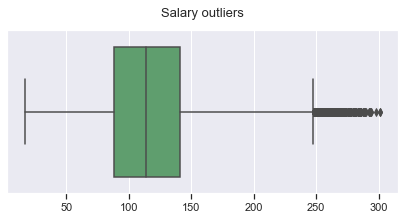

In [11]:
# Plot box graph to check outliers
pg = plotGraph()
fig1 = plt.figure(figsize=(7, 3))
pg.plotBox(dataH.trainAll['salary'], fig1, 'Salary outliers', whis = 2.0)
plt.show()

In [12]:
# See categorical features statistics
dataA = dataAnalysis()
catDF = dataA.objectCheck(dataH.trainAll, 10, 'object', dataH.mergeCol)
catDF.style.highlight_max(subset=['unique','freq'], color='skyblue').highlight_min(subset=['unique','freq'], color='tomato')

jobType --> ['CFO', 'CEO', 'VICE_PRESIDENT', 'MANAGER', 'JUNIOR', 'JANITOR', 'CTO', 'SENIOR']
degree --> ['MASTERS', 'HIGH_SCHOOL', 'DOCTORAL', 'BACHELORS', 'NONE']
major --> ['MATH', 'NONE', 'PHYSICS', 'CHEMISTRY', 'COMPSCI', 'BIOLOGY', 'LITERATURE', 'BUSINESS', 'ENGINEERING']
industry --> ['HEALTH', 'WEB', 'AUTO', 'FINANCE', 'EDUCATION', 'OIL', 'SERVICE']




,count,unique,top,freq
companyId,999995,63,COMP39,16193
jobType,999995,8,SENIOR,125886
degree,999995,5,HIGH_SCHOOL,236975
major,999995,9,NONE,532353
industry,999995,7,WEB,143205


* **Features distribution**

Plot the distribution of the numerical features to analysis.

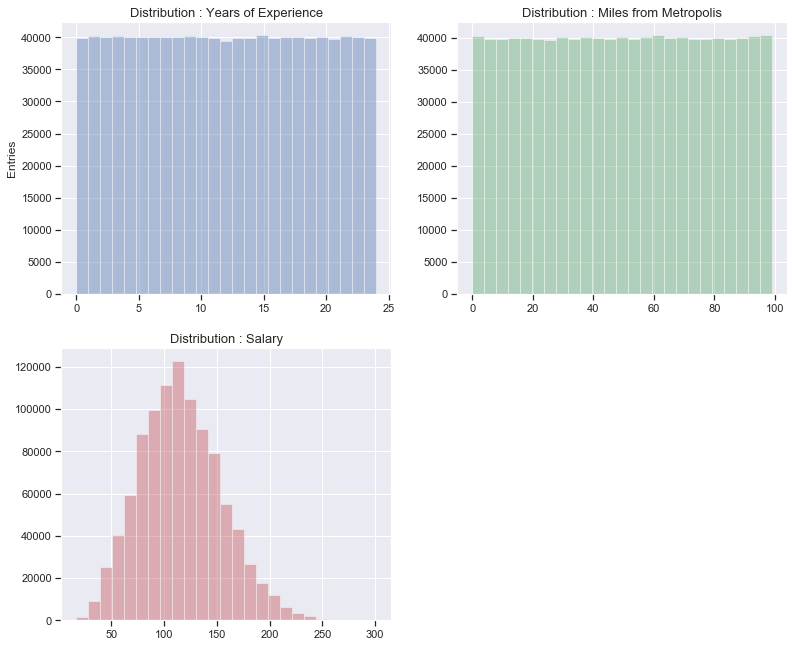

In [13]:
# Draw distibution plot for numerical features.
i = 0
fig1 = plt.figure(figsize=(13,11))
for col, name in zip(dataH.numFeaturesTarg, dataH.numFeaturesTargP):
    pg.plotDist(dataH.trainAll[col], fig1.add_subplot(2,2,i+1), 'Distribution : {}'.format(name), 
                bins = 25, plotC = pg.colors[i] , yLbl = '' if i != 0 else 'Entries')
    i +=1
plt.show()

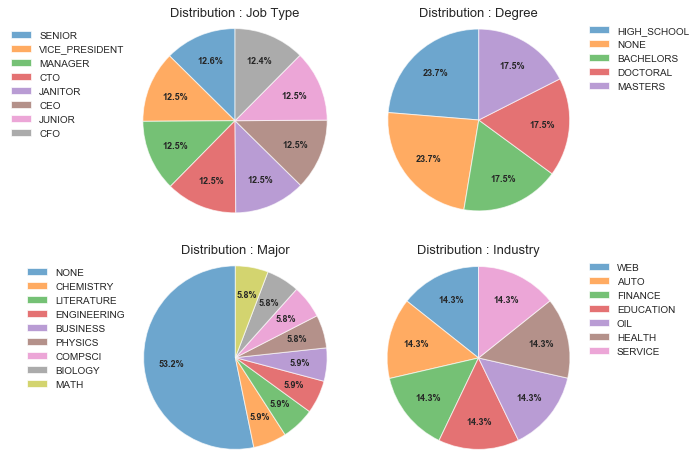

In [14]:
# Plot pie chart for feature distribution
i = 1
fig1= plt.figure(figsize = (8,8))
for item, name in zip(dataH.catFeaturesN, dataH.catFeaturesNP):   
    if len(dataH.trainAll[item].unique()) < 10 :
        tmpDF = dataH.trainAll.groupby(item).count().sort_values(by=dataH.targetN, ascending = False)
        ax = fig1.add_subplot(2,2,i)
        pg.plotPie(tmpDF[dataH.targetN], ax, pieColors, 'Distribution : {}'.format(name), 
                   legLoc = [1, 1.025] if i % 2 == 0 else [0,1], titleFS = 13 ,pieFS = 9, pct = True)        
        i += 1
plt.show()

* **Correlation matrix**

To finish, we check the correlation among the features in a correlation heatmap graph.

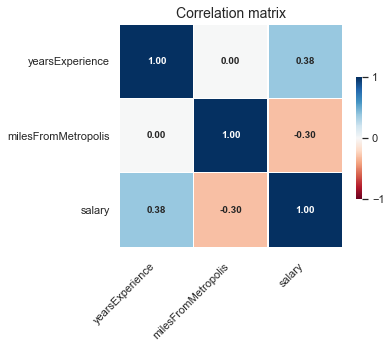

In [15]:
# Plot correlation matrix
fig1= plt.figure(figsize = (5,5))
pg.plotCorr(dataH.trainAll.corr(), fig1, 'Correlation matrix', titleFS = 14, cmap = 'RdBu', ticksFS = 11, 
            rot = 45,cbarD={'shrink': 0.45, 'ticks':[-1,0,1]}, annD={'size': 10, 'weight' : 'bold'},
            yLim = [1.02,0.0])
plt.show()

## 3. Exporatory data analysis

* **Features statistics analysis**

Calculate means and ranges of the target feature by company and jobtype, draw the salary mean and STD range for the two numerical features, and finally the salary average by categorical features to get a deep insight on the data.

In [16]:
# Generate range of salary per company and analyze it in ranges
print('Global mean salary --> {:.2f}'.format(dataH.trainAll[dataH.targetN].mean()))
tmpDF = dataA.aggData(dataH.trainAll,'companyId',dataH.targetN, np.mean)
tmpDF2 = dataA.aggData(dataH.trainAll, ['companyId','jobType'], dataH.targetN,
                       np.mean, sort = ['companyId','jobType'], asc = False)
tmpDF2 = dataA.pivotData(tmpDF2, 'jobType','companyId', dataH.targetN)
tmpDF3 = dataA.rangeAnalysis(tmpDF, dataH.targetN, tmpDF2)
tmpDF3.style.highlight_max(color='skyblue').highlight_min(color='tomato')

Global mean salary --> 116.06
Min mean salary per company -->115.34
Max mean salary per company -->116.79
Range between --> 1.45
Salary range mean per company and jobType --> 3.23



companyId,Min,Max,Range
jobType,,,
CEO,143.252708,147.632727,4.380020
CFO,133.896570,137.330107,3.433537
CTO,133.918050,137.123925,3.205875
JANITOR,69.481382,71.996976,2.515594
JUNIOR,93.744734,96.569827,2.825093
MANAGER,114.172959,117.280284,3.107325
SENIOR,103.640387,107.143808,3.503421
VICE_PRESIDENT,123.956219,126.814834,2.858615


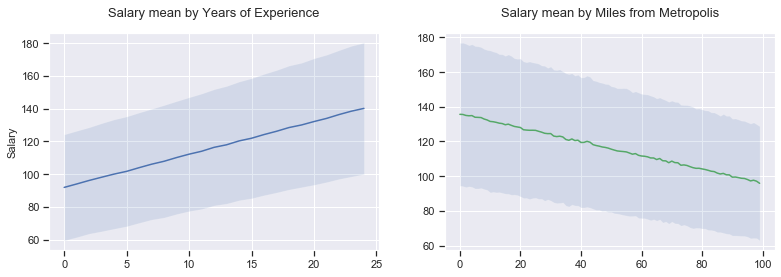

In [17]:
# Plot line chart on salary mean and STD for numerical features
i = 0
fig1 = plt.figure(figsize=[13,4])
pg.setStyle('darkgrid')
for feat, name in zip(dataH.numFeaturesN, dataH.numFeaturesNP):
    meanDF = dataA.aggData(dataH.trainAll, feat, dataH.targetN, np.mean)
    stdDF = dataA.aggData(dataH.trainAll, feat, dataH.targetN, np.std)
    pg.plotMean(meanDF[dataH.targetN], stdDF[dataH.targetN], fig1.add_subplot(1,2,i+1), '', 
                dataH.targetNP if i == 0 else '', '{} mean by {}'.format(dataH.targetNP, name), 
                lblFS = 11, titleFS = 13, plotC = pg.colors[i])
    i += 1
plt.show()

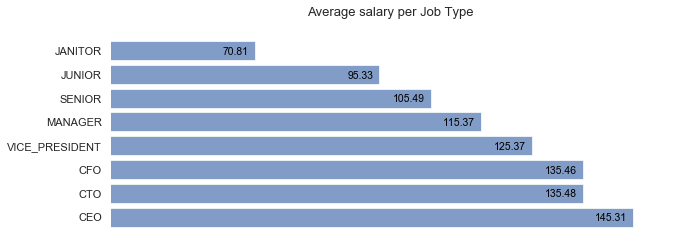

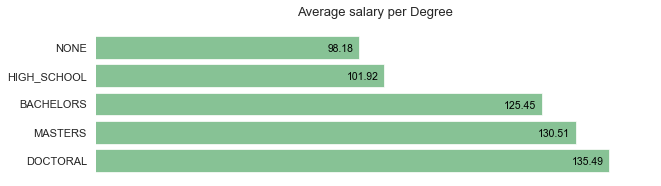

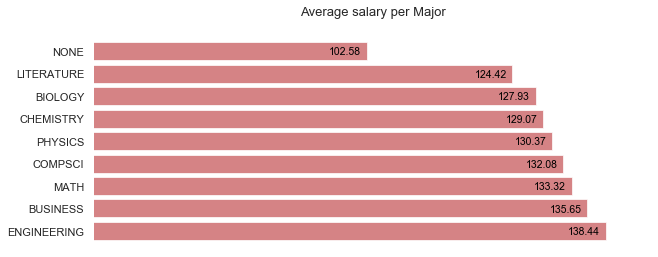

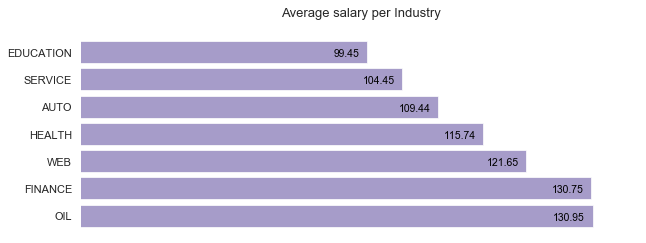

In [18]:
# Show salary mean per feature categories
i = 0
for feat, name in zip(dataH.catFeaturesN, dataH.catFeaturesNP):
    lenCat = len(dataH.trainAll[feat].unique())
    if lenCat < 10 :
        tmpDF = dataA.aggData(dataH.trainAll, feat, dataH.targetN, np.mean, 
                              sort = dataH.targetN, asc = False)
        figH = 2.75 if lenCat < 6 else 3.75
        figH = 4 if lenCat > 8 else figH
        fig1 = plt.figure(figsize=(10, figH))
        pg.plotBarH(tmpDF[feat],tmpDF[dataH.targetN], fig1,'Average salary per '+ name,
                    0.85, 1, nType = 'double', plotC = pg.colors[i], fontS = 10.5, 
                    sep = [3.75, 4.25] if i == 0 else [2.75, 3.25])
        i +=1
plt.show()

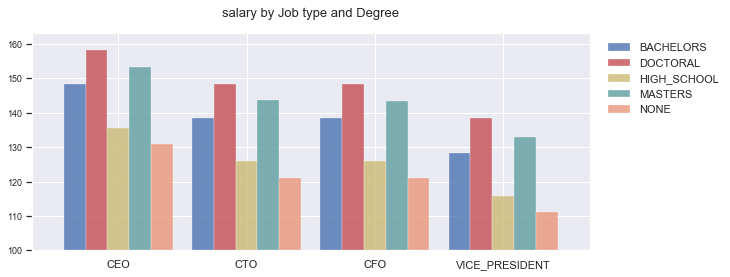

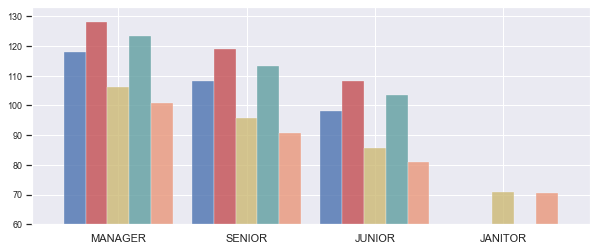

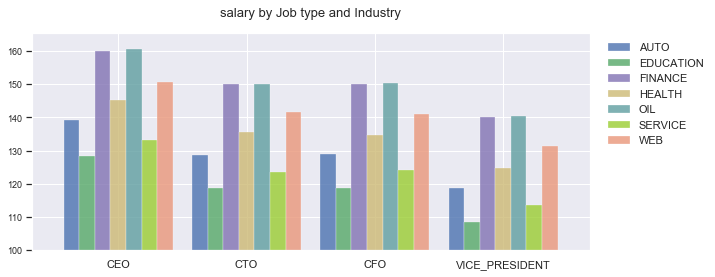

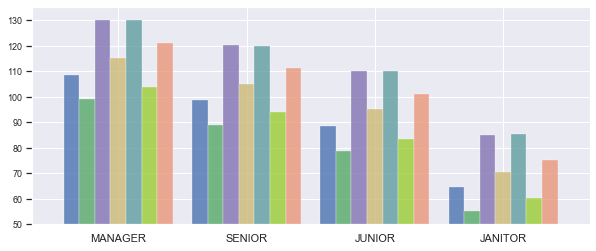

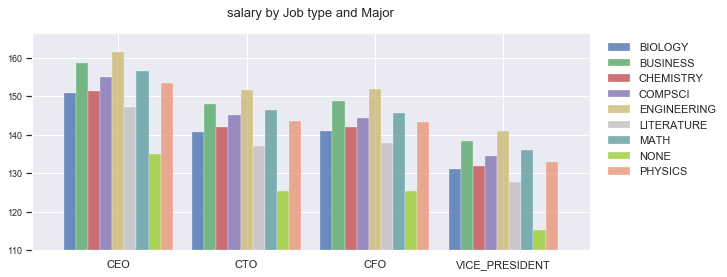

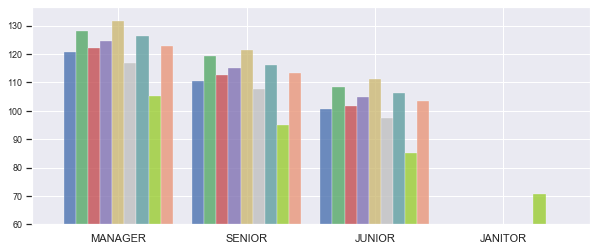

In [19]:
# Show salary mean per job type and other feature categories
i = 0
lstAgg = [['degree', 'jobType'], ['industry', 'jobType'],['major', 'jobType']]
lstCol = [['CEO','CTO', 'CFO', 'VICE_PRESIDENT'],
          ['MANAGER','SENIOR', 'JUNIOR', 'JANITOR']]
lstTitles = ['Job type and Degree', 'Job type and Industry','Job type and Major']
i = 0
for aggV in lstAgg:
    tmpDF = dataA.aggData(dataH.trainAll, aggV, dataH.targetN, np.mean)
    tmpDF = dataA.pivotData(tmpDF, aggV[1], aggV[0], dataH.targetN)
    strTitle = '{} by {}'.format(dataH.targetN, lstTitles[i])
    i +=1
    bLeg = True
    for df in [tmpDF.loc[lstCol[0]],tmpDF.loc[lstCol[1]]]:
        yLim = (np.min(df.min())-5, np.max(df.max())+5)
        pg.plotMultBar(df, [10,4], strTitle, yLim, yTicksFS = 9, bLeg = bLeg, legLoc = [1.015,1])
        strTitle = ''
        bLeg = False

## 4. Data split and features engineering

* **Data split and features engineering**

First, we'll split the data into *Train* and *Validation* sets. Then, we'll process the data to create new features to feed the models.

In [20]:
# Split data into train and validation dataset.
dataH.splitTrainVal(dataH.trainAll, dataH.trainAll[dataH.featuresN], dataH.trainAll[dataH.targetN])

Data splitted in train and test datasets

Full dataset shape   -->  (999995, 9)
Train features shape -->  (799996, 7)
Test features shape  -->  (199999, 7)
Train target shape   -->  (799996,)
Test target shape    -->  (199999,)



In [21]:
# Create new features
ftCreator = featuresTransform()
print('### Train data ###\n')
dataH.trainX = ftCreator.createFeatures(dataH.trainX, dataH.trainY, fit_transform = True)
print('\n### Validation data ###\n')
dataH.valX = ftCreator.createFeatures(dataH.valX, dataH.valY, transform = True)
print('\n### Test data ###\n')
dataH.testF = dataH.dropCols(dataH.testF)
dataH.testF = ftCreator.createFeatures(dataH.testF, dataH.valY, transform = True)
print('\nData pre-processing completed.')

# Check Dataset
dataH.trainX.head()

### Train data ###

hasMajor feature created.
mean_SalaryGroup feature created.
std_SalaryGroup feature created.
min_SalaryGroup feature created.
max_SalaryGroup feature created.
companyId feature updated.
jobType feature encoded.
degree feature encoded.
major feature encoded.
industry feature encoded.

### Validation data ###

hasMajor feature created.
mean_SalaryGroup feature created.
std_SalaryGroup feature created.
min_SalaryGroup feature created.
max_SalaryGroup feature created.
companyId feature updated.
jobType feature encoded.
degree feature encoded.
major feature encoded.
industry feature encoded.

### Test data ###

hasMajor feature created.
mean_SalaryGroup feature created.
std_SalaryGroup feature created.
min_SalaryGroup feature created.
max_SalaryGroup feature created.
companyId feature updated.
jobType feature encoded.
degree feature encoded.
major feature encoded.
industry feature encoded.

Data pre-processing completed.


,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,hasMajor,mean_SalaryGroup,std_SalaryGroup,min_SalaryGroup,max_SalaryGroup
115988,37,2,2,8,5,14,53,1,133.250000,23.427904,97,175
487332,28,4,1,0,0,19,14,0,112.455285,24.454123,69,175
456712,36,7,1,0,4,2,86,0,122.057851,18.697280,77,161
63927,31,5,4,2,0,0,60,1,101.500000,13.810531,73,122
727616,30,0,0,0,5,23,13,0,106.129139,24.736080,55,175


## 5. Model development

* **Baseline**

To begin the modeling phase, we create a *baseline* predictions to compare against the models to be developed. In this case, the predictions will be the mean salary value grouped by *jobType* and *companyId*.  

In [22]:
# Create the baseline
dataA.createBaseline(dataH.trainX, dataH.trainY, dataH.bslFeatures)

Baseline RMSE --> 47.6583


* **Model development and validation**

To approach this problem, we've selected 3 algorithms, *Linear regression*, *Random forest regressor*, *XGboost regressor*. We've previously tuned the models using GridSearchCV. The model that achieved the lowest error was **_XGBoost_**, closely followed by the *Random Forest*, which has been 7 times slower in its execution.

Evaluating Linear Regression...
Evaluating Random Forest...
Evaluating XGBoost...
Displaying CV results...



<Figure size 720x288 with 0 Axes>

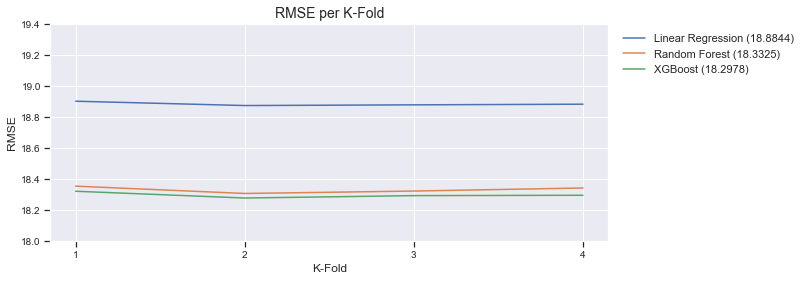

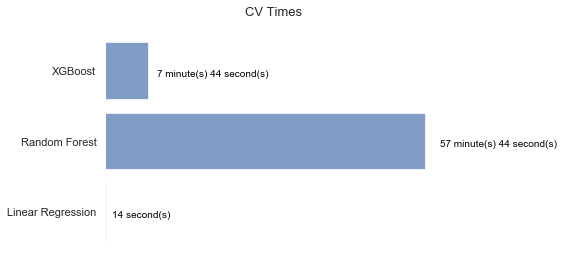

In [23]:
# Models to be tested
LR_Regressor = LinearRegression(n_jobs = 3)
RF_Regressor = RandomForestRegressor(max_features = 0.5, max_depth = 10,  n_estimators = 500,
                                     min_samples_split = 8, min_samples_leaf = 8,
                                     random_state = rndSt, n_jobs = 3)
XGB_Regressor = xgb.XGBRegressor(learning_rate =0.057, n_estimators=150, max_depth=4, gamma=0,
                                 min_child_weight=8, subsample = 0.925, colsample_bytree = 0.975, 
                                 reg_alpha =  72, early_stopping_rounds = 15, random_state = rndSt, 
                                 objective = 'reg:squarederror', n_jobs = 3, verbosity = 0)

# Check model performance
scaler = MinMaxScaler()
modelM = [LR_Regressor, RF_Regressor, XGB_Regressor]
modelN = ['Linear Regression', 'Random Forest', 'XGBoost']
modelS = []
for model, name in zip(modelM, modelN):
    print('Evaluating {}...'.format(name))
    pipe = Pipeline([('scaler', scaler),('model',model)])
    CVScores = dataA.CVS(pipe, name, dataH.trainX, dataH.trainY)
    modelS.append(CVScores)

# Display results analysis
print('Displaying CV results...\n')
fig1 = plt.figure(figsize = [10,4])
fig2 = plt.figure(figsize = [10,4])
lstTitle = ['K-Fold', 'RMSE', 'RMSE per K-Fold', 'CV Times']
dataA.showCVResults(modelS, [fig1, fig2], lstTitle, sep = [375, 700, 800], div = 2.5)

* **Best model selection and feature importance**

Even if the Linear Regression model error is the highest, we evaluate all 3 with the validation set. The **_XGBoost_** gets the smaller RMSE but the difference is really small with the other models. 

Bear in mind, the time the models take to train and predict. Finally, we display the most predictive features, being the *mean_salaryGroup* the one with the most predictive power.

##### Linear Regression #####

     - Evaluating model on validation data...
     - RMSE --> 19.8220
     - Time --> 2 second(s)

##### Random Forest #####

     - Evaluating model on validation data...
     - RMSE --> 19.7116
     - Time --> 19 minute(s) 54 second(s)

##### XGBoost #####

     - Evaluating model on validation data...
     - RMSE --> 19.5923
     - Time --> 2 minute(s) 44 second(s)

== BEST MODEL ==

     XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.975,
             early_stopping_rounds=15, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.057, max_delta_step=0, max_depth=4,
             min_child_weight=8, missing=nan, monotone_constraints='()',
             n_estimators=150, n_jobs=3, num_parallel_tree=1,
             objective='reg:squarederror', random_state=14, reg_alpha=72,
             reg_lambda=1, scale_pos_weight=1, subs

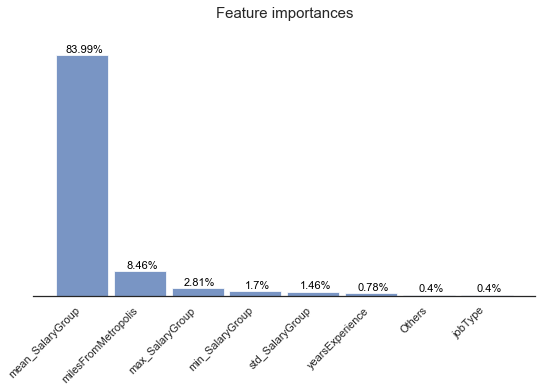

In [24]:
# Fit and predict with validation dataset, and select the models that performs the best
modelM = [LR_Regressor, RF_Regressor, XGB_Regressor]
modelN = ['Linear Regression', 'Random Forest', 'XGBoost']
modelH = modelHandler()
bestM = modelH.modelSelection(dataH.trainX, dataH.trainY, dataH.valX, dataH.valY, modelM, modelN)

# Plot the best model feature importance
fig1 = plt.figure(figsize=[9,5])
modelH.featImp(bestM[0], dataH.trainX.columns, fig1)

* **Save model and predictions to disk**

Finally, we dump the best model to a file for further uses, and make the predictions over the test data and save it to a CSV file.

In [25]:
# Predict and save
modelH.saveAndPredict(bestM[0], dataH.testF)

Model saved to file.
Predictions exported
Process completed!
